In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# path where resulting .csv files for cases and stringencies are stored

csv_filepath = os.path.abspath(os.path.join(os.pardir, os.pardir, 'prescriptions'))
csv_filepath

'/home/thinng/code/2020/covid-xprize-comp_40/prescriptions'

In [3]:
# dictionary storing prescriptor files in format model_name: path_to_file
prescription_files = {
    'BlindGreedy': os.path.join(csv_filepath, 'BlindGreedy_cloned.csv'),
#     'Heuristic': os.path.join(csv_filepath, 'Heuristic_pct_5_cloned.csv'),
    'Heuristic': os.path.join(csv_filepath, 'Heuristic_pct_8.csv'),
    'Neat2D': os.path.join(csv_filepath, 'neat_evaluate_2D_big_test.csv'),
    
}

In [4]:
def load_data(filepath):
    latest_df = pd.read_csv(filepath,
                            encoding="ISO-8859-1",
                            dtype={"RegionName": str},
                            error_bad_lines=False)
    return latest_df

In [5]:
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):    
    df = load_data(prescription_file)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)

In [6]:
# Compute domination relationship for each pair of prescriptors for each geo
def compute_domination_df(df, verbose=False):
    country_names = []
    region_names = []
    dominating_names = []
    dominated_names = []
    dominated_idxs = []
    prescriptor_names = sorted(df['PrescriptorName'].unique())  # Greedy, Greedy2
    prescription_idxs = sorted(df['PrescriptionIndex'].unique())  # 0-9
    for country_name in df['CountryName'].unique():
        cdf = df[df['CountryName'] == country_name]
        for region_name in cdf['RegionName'].unique():
            if verbose:
                print('Computing domination for', country_name, region_name)
            if pd.isna(region_name):
                rdf = cdf[cdf['RegionName'].isna()]
            else:
                rdf = cdf[cdf['RegionName'] == region_name]
            for name1 in prescriptor_names:
                dominated_prescriptions = set() # To collect all dominated prescriptions
                                                # this is a set, so each dominated
                                                # prescription is only counted once per
                                                # submission.
                name1_df = rdf[rdf['PrescriptorName'] == name1]
                name1_idxs = sorted(name1_df['PrescriptionIndex'].unique())
                for i in name1_idxs:
                    idf = name1_df[name1_df['PrescriptionIndex'] == i]
                    i_cases = idf['PredictedDailyNewCases'].values[0]
                    i_stringency = idf['Stringency'].values[0]
                    
                    # Compare name1 to all other prescriptions
                    for name2 in prescriptor_names:
                        if name1 != name2:
                            name2_df = rdf[rdf['PrescriptorName'] == name2]
                            name2_idxs = sorted(name2_df['PrescriptionIndex'].unique())  
                            for j in name2_idxs:
                                jdf = name2_df[name2_df['PrescriptionIndex'] == j]
                                j_cases = jdf['PredictedDailyNewCases'].values[0]
                                j_stringency = jdf['Stringency'].values[0]
                                if (i_cases < j_cases) and (i_stringency < j_stringency):
                                    dominated_prescriptions.add((name2, j))
                for name2, j in dominated_prescriptions:
                    country_names.append(country_name)
                    region_names.append(region_name)
                    dominating_names.append(name1)
                    dominated_names.append(name2)
                    dominated_idxs.append(j)
    ddf = pd.DataFrame({
        'CountryName': country_names,
        'RegionName': region_names,
        'DominatingName': dominating_names,
        'DominatedName': dominated_names,
        'DominatedIndex': dominated_idxs})
    return ddf

In [7]:
# Get number of dominated prescriptions for each submission on each test. This is the "Domination Count"
for test_name in df['TestName'].unique():
    print('Test', test_name)
    df_test = df[df['TestName'] == test_name]
    ddf = compute_domination_df(df_test)
    print(ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex'])
    print()

Test EQUAL
DominatingName
Heuristic      1670
Neat2D         1581
BlindGreedy       9
Name: DominatedIndex, dtype: int64

Test RANDOM1
DominatingName
Heuristic      1880
Neat2D         1524
BlindGreedy     934
Name: DominatedIndex, dtype: int64

Test RANDOM2
DominatingName
Heuristic      1900
Neat2D         1424
BlindGreedy     886
Name: DominatedIndex, dtype: int64

Test RANDOM3
DominatingName
Heuristic      1791
Neat2D         1479
BlindGreedy    1067
Name: DominatedIndex, dtype: int64

Test RANDOM4
DominatingName
Heuristic      1173
BlindGreedy     527
Name: DominatedIndex, dtype: int64

Test RANDOM5
DominatingName
Heuristic      1199
BlindGreedy     511
Name: DominatedIndex, dtype: int64

Test RANDOM6
DominatingName
Heuristic      1085
BlindGreedy     604
Name: DominatedIndex, dtype: int64

Test RANDOM7
DominatingName
Heuristic      1158
BlindGreedy     512
Name: DominatedIndex, dtype: int64

Test RANDOM8
DominatingName
Heuristic      1150
BlindGreedy     485
Name: DominatedIndex, 

In [8]:
import operator

# Get number of points in pts that are Pareto dominated by the point pt
def num_dominate(pt,pts):
    strictly_worse = (pts > pt).all(axis=-1)
    return strictly_worse

PrescriptorNames = list(df['PrescriptorName'].unique()) 
TestNames = list(df['TestName'].unique()) 
test_prescriptor_best = {}
test_prescriptor_all = {}

for TestName in TestNames:
    for ii in range(len(PrescriptorNames)-1):
        for jj in range(ii+1, len(PrescriptorNames)):
            PrescriptorName1 = PrescriptorNames[ii]
            PrescriptorName2 = PrescriptorNames[jj]
            df1 = df[ df['TestName'] == TestName ]
            df1['geoid'] = df1['CountryName'].apply(str) + '_' + df1['RegionName'].apply(str)
            df1['tpl'] = df1.apply(lambda x: (x.PredictedDailyNewCases, x.Stringency), axis=1)
            geoids = df1['geoid'].unique()
            d1 = []
            d2 = []
            for geoid in geoids:
                df2 = df1[ df1['geoid']==geoid ]
                df2 = df2.sort_values(by=['PrescriptionIndex'])
                s1 = df2[ df2['PrescriptorName'] == PrescriptorName1 ] 
                s2 = df2[ df2['PrescriptorName'] == PrescriptorName2 ] 
                s1 = list( s1['tpl'] )
                s2 = list( s2['tpl'] )
                s1 = np.array(s1)
                s2 = np.array(s2)
                if (( len(s1)>0 ) and ( len(s2)>0 ) ):
                    d1 += [  num_dominate(e,s2) for e in s1 ]  
                    d2 += [  num_dominate(e,s1) for e in s2 ]  
                else:
                    break
            if (( len(d1)>0 ) and ( len(d2)>0 ) ):
                d1 = np.array(d1)*1
                d1 = np.sum(d1,axis=0)
                d1_best = np.max(d1)
                d1_all = np.sum(d1)
                d2 = np.array(d2)*1
                d2 = np.sum(d2,axis=0)
                d2_best = np.max(d2)
                d2_all = np.sum(d2)
                try:
                    test_prescriptor_best[(TestName,PrescriptorName1)] += d1_best
                except:
                    test_prescriptor_best[(TestName,PrescriptorName1)] = d1_best
                try:
                    test_prescriptor_best[(TestName,PrescriptorName2)] += d2_best
                except:
                    test_prescriptor_best[(TestName,PrescriptorName2)] = d2_best

                try:
                    test_prescriptor_all[(TestName,PrescriptorName1)] += d1_all
                except:
                    test_prescriptor_all[(TestName,PrescriptorName1)] = d1_all
                try:
                    test_prescriptor_all[(TestName,PrescriptorName2)] += d2_all
                except:
                    test_prescriptor_all[(TestName,PrescriptorName2)] = d2_all
              
            
print('--------------Result for best prescriptor:--------------\n\n')            
for TestName in TestNames:
    try:
        print(TestName)
        d = dict([(k,test_prescriptor_best[(TestName,k)]) for k in PrescriptorNames])
        sorted_x = sorted(d.items(), key=operator.itemgetter(1))[::-1]
        for e in sorted_x:
            print(e[0], ':', e[1])
        print()
    except:
        pass
    
print('--------------Result for all prescriptors:--------------\n\n')            
for TestName in TestNames:
    try:
        print(TestName)
        d = dict([(k,test_prescriptor_all[(TestName,k)]) for k in PrescriptorNames])
        sorted_x = sorted(d.items(), key=operator.itemgetter(1))[::-1]
        for e in sorted_x:
            print(e[0], ':', e[1])
        print()    
    except:
        pass

--------------Result for best prescriptor:--------------


EQUAL
Neat2D : 650
Heuristic : 502
BlindGreedy : 6

RANDOM1
Heuristic : 645
Neat2D : 471
BlindGreedy : 336

RANDOM2
Heuristic : 619
Neat2D : 441
BlindGreedy : 304

RANDOM3
Heuristic : 591
Neat2D : 472
BlindGreedy : 363

RANDOM4
RANDOM5
RANDOM6
RANDOM7
RANDOM8
RANDOM9
RANDOM10
Jan_RC_NoDec_fast
Default
Jan_Mar_EC_fast
Jan_Mar_RC_fast
--------------Result for all prescriptors:--------------


EQUAL
Heuristic : 2634
Neat2D : 2070
BlindGreedy : 9

RANDOM1
Heuristic : 3764
Neat2D : 2422
BlindGreedy : 1931

RANDOM2
Heuristic : 3563
Neat2D : 2251
BlindGreedy : 1628

RANDOM3
Heuristic : 3347
Neat2D : 2390
BlindGreedy : 2050

RANDOM4
RANDOM5
RANDOM6
RANDOM7
RANDOM8
RANDOM9
RANDOM10
Jan_RC_NoDec_fast
Default
Jan_Mar_EC_fast
Jan_Mar_RC_fast


In [9]:
#
# Helpful functions for visualizing the area dominated by a set of solutions.
#

def compute_pareto_set(objective1_list, objective2_list):
    """
    Return objective values for the subset of solutions that
    lie on the pareto front.
    """
    
    assert len(objective1_list) == len(objective2_list), \
            "Each solution must have a value for each objective."
        
    n_solutions = len(objective1_list)
    
    objective1_pareto = []
    objective2_pareto = []
    for i in range(n_solutions):
        is_in_pareto_set = True
        for j in range(n_solutions):
            if (objective1_list[j] < objective1_list[i]) and \
                    (objective2_list[j] < objective2_list[i]):
                is_in_pareto_set = False
        if is_in_pareto_set:
            objective1_pareto.append(objective1_list[i])         
            objective2_pareto.append(objective2_list[i])   
    
    return objective1_pareto, objective2_pareto

    
def plot_pareto_curve(objective1_list, objective2_list, color=None, linestyle='-'):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys, color=color, linestyle=linestyle)

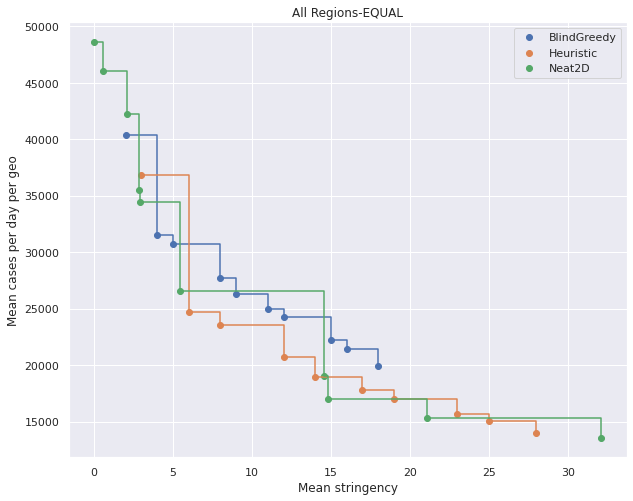

Test Jan_RC_NoDec_fast not found for prescriptor Neat2D


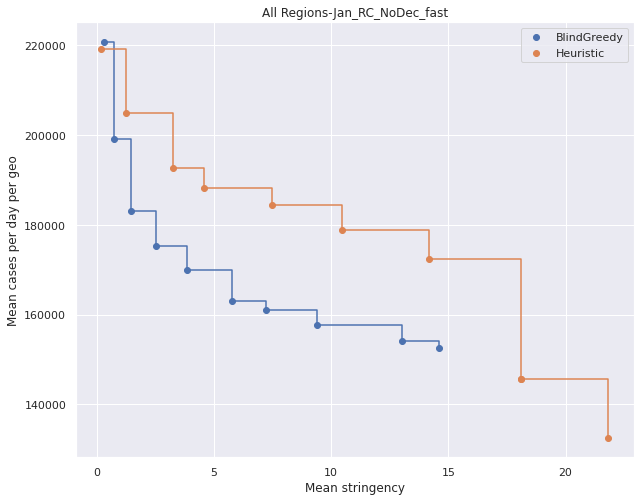

Test Default not found for prescriptor BlindGreedy
Test Default not found for prescriptor Heuristic


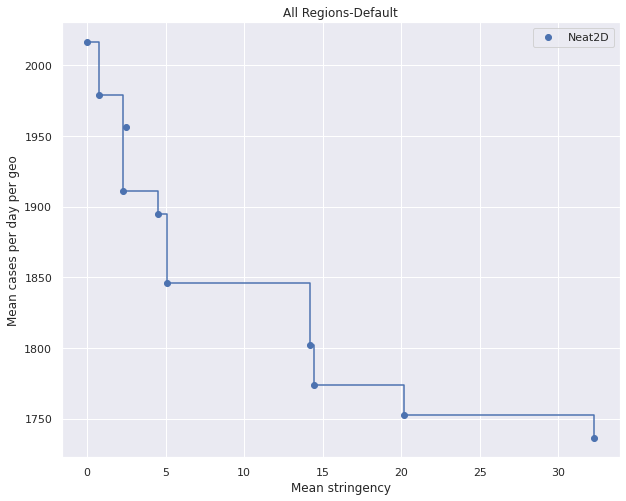

Test Jan_Mar_EC_fast not found for prescriptor BlindGreedy
Test Jan_Mar_EC_fast not found for prescriptor Heuristic


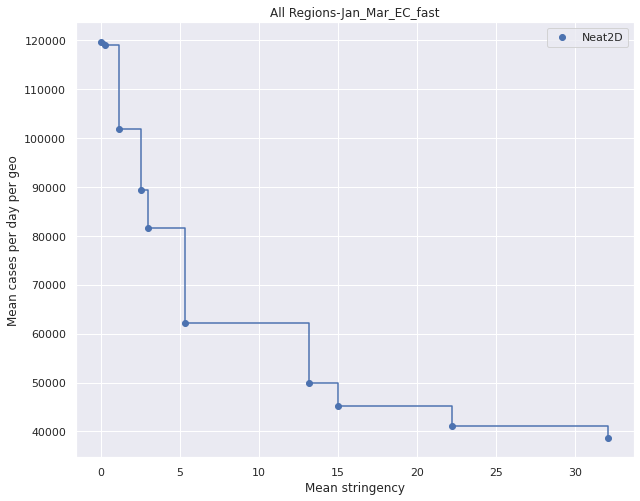

Test Jan_Mar_RC_fast not found for prescriptor BlindGreedy
Test Jan_Mar_RC_fast not found for prescriptor Heuristic


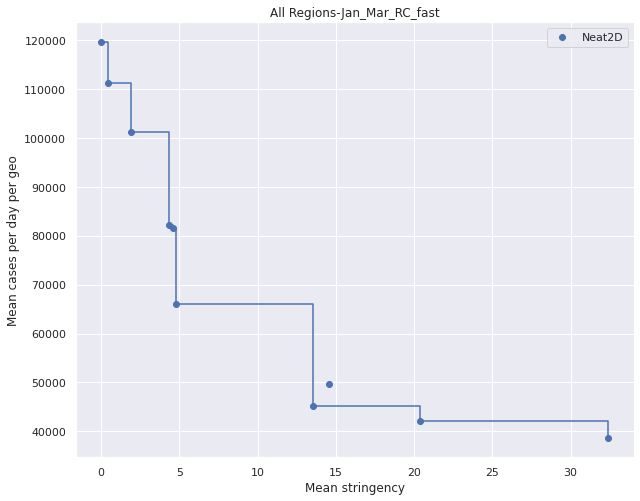

In [10]:
sns.set_theme()

# Plot overall stringency and cases of each prescription

for test_name in df['TestName'].unique():  # plot for each test
    if 'RANDOM' in test_name:  # RANDOM tests will be plotted in the next cell, so skip them now
        continue
    
    plt.figure(figsize=(10,8))
    for prescriptor_name in prescription_files:
        pdf = df[df['PrescriptorName'] == prescriptor_name]
        pdf = pdf[pdf['TestName'] == test_name]
        if pdf.empty:
            print('Test {} not found for prescriptor {}'.format(test_name, prescriptor_name))
            continue
        overall_pdf = pdf.groupby(['PrescriptionIndex', ]).mean().reset_index()
        plt.scatter(overall_pdf['Stringency'],
                    overall_pdf['PredictedDailyNewCases'], 
                    label=prescriptor_name)
        plot_pareto_curve(list(overall_pdf['Stringency']),
                         list(overall_pdf['PredictedDailyNewCases']))
    plt.xlabel('Mean stringency')
    plt.ylabel('Mean cases per day per geo')
    plt.title('All Regions' + '-' + test_name)
    plt.legend()
    plt.show()

Found 10 RANDOM* tests for prescriptor BlindGreedy
Found 10 RANDOM* tests for prescriptor Heuristic
Found 3 RANDOM* tests for prescriptor Neat2D


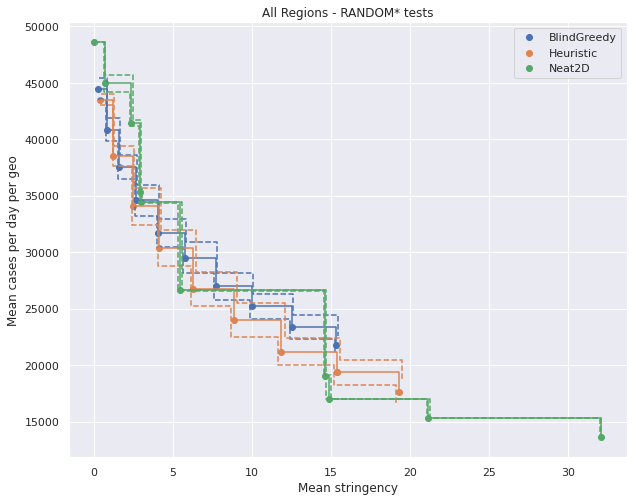

In [11]:
# Plot mean curve +/- std for RANDOM* tests

plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    rand_tests = [test_name for test_name in pdf['TestName'].unique() if 'RANDOM' in test_name]
    if not rand_tests:
        print('No RANDOM* tests found for prescriptor {}'.format(prescriptor_name))
        continue

    print('Found {} RANDOM* tests for prescriptor {}'.format(len(rand_tests), prescriptor_name))
    rand_pdf = pdf[pdf['TestName'].isin(rand_tests)]
    overall_pdf = rand_pdf.groupby(['TestName','PrescriptionIndex']).mean().reset_index()
    pdf_mean = overall_pdf.groupby('PrescriptionIndex').mean().reset_index()
    pdf_std = overall_pdf.groupby('PrescriptionIndex').std().reset_index()
    
    plt.scatter(pdf_mean['Stringency'],
                pdf_mean['PredictedDailyNewCases'],
                label=prescriptor_name)
    plot_pareto_curve(list(pdf_mean['Stringency']),
                      list(pdf_mean['PredictedDailyNewCases']))
    color = plt.gca().lines[-1].get_color()
    
    plot_pareto_curve(list(pdf_mean['Stringency']-pdf_std['Stringency']),
                      list(pdf_mean['PredictedDailyNewCases']-pdf_std['PredictedDailyNewCases']),
                      color=color,
                      linestyle='dashed')
    
    plot_pareto_curve(list(pdf_mean['Stringency']+pdf_std['Stringency']),
                      list(pdf_mean['PredictedDailyNewCases']+pdf_std['PredictedDailyNewCases']),
                      color=color,
                      linestyle='dashed')
    
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.title('All Regions - RANDOM* tests')
plt.legend()
plt.show()

Test Jan_RC_NoDec_fast and/or region Canada not found for prescriptor Neat2D


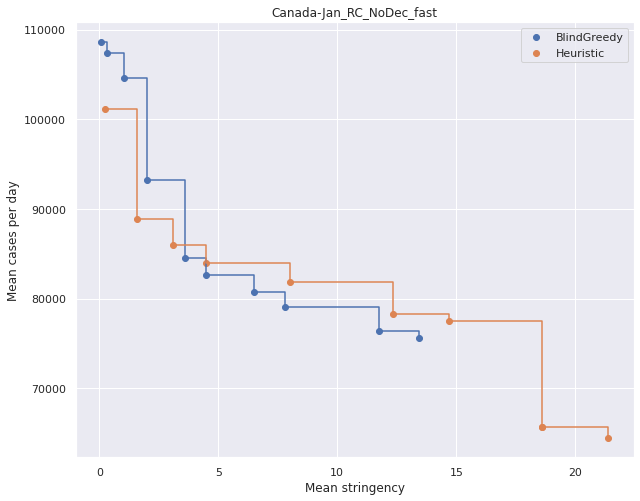

In [12]:
# Plot stringency and cases of each prescription for a particular country and specific test

country_name = 'Canada'
test_name = 'Jan_RC_NoDec_fast'

cdf = df[df['CountryName'] == country_name]
cdf = cdf[cdf['TestName'] == test_name]

plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = cdf[cdf['PrescriptorName'] == prescriptor_name]
    if pdf.empty:
        print('Test {} and/or region {} not found for prescriptor {}'.format(test_name, country_name, prescriptor_name))
        continue
    plt.scatter(pdf['Stringency'],
                pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(pdf['Stringency']),
                      list(pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day')
plt.title(country_name + '-' + test_name)
plt.legend()
plt.show()